---

# Simplified Access to Veluwe Ecological Data Through Open Geospatial APIs

**Author:** Hudson Passos  
**Internship Host:** Netherlands Institute of Ecology (NIOO-KNAW)  
**Host Supervisor:** Stefan Vriend (NIOO-KNAW)  
**WUR Supervisor:** Liesbeth Bakker (WUR, NIOO-KNAW)  
**Repository:** [research-project-internship-nioo](https://github.com/hudsonpassos/research-project-internship-nioo)  
**Date:** April 29, 2025  
**Python Version:** 3.11.9  
**License:** MIT  
**Description:**  
This notebook is part of a research internship project. It focuses on the automated selection, filtering, 
and preprocessing of open ecological geospatial datasets for the Veluwe region using OGC APIs (WMS, WFS, WCS).


---

## **Part 1: Nationaal Georegister (NGR)**

🔗 [Nationaal Georegister website](https://www.nationaalgeoregister.nl/geonetwork/srv/dut/catalog.search#/home)


---

**Packages**

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import time
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import contextily as cx
from shapely.geometry import box
from owslib.wms import WebMapService
from PIL import Image
from io import BytesIO
import os
import numpy as np
from tqdm import tqdm
import certifi
from urllib.parse import urlparse
from rasterio.io import MemoryFile
from owslib.wcs import WebCoverageService
from rasterio.plot import show
import matplotlib.pyplot as plt
from pathlib import Path
from xml.etree import ElementTree as ET

**Setting pathways**

In [2]:
root = "C:/Users/hudso/OneDrive/Documents/02. WUR/11. INTERNSHIP"
outlines_path = os.path.join(root, "02 data/outlines")
output_path = os.path.join(root, "05 python_project/output")

**Loading outlines**

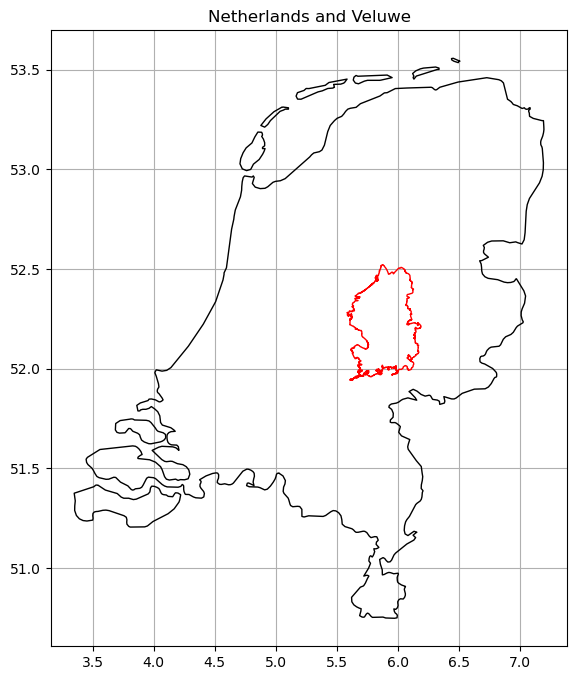

In [3]:
NLshp_path = os.path.join(outlines_path, "ne_10m_admin_0_countries/ne_10m_NL.shp")
VELshp_path = os.path.join(outlines_path, "nationaal_landschap/Veluwe_outline_simplified.shp")

NLgdf = gpd.read_file(NLshp_path)
VELgdf = gpd.read_file(VELshp_path)

# Filter Netherlands
netherlands = NLgdf[NLgdf["NAME"] == "Netherlands"].to_crs(epsg=4326)
veluwe = VELgdf.to_crs(epsg=4326)

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Netherlands border
netherlands.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot Veluwe border
veluwe.boundary.plot(ax=ax, color='red', linewidth=1)

# Optional: Add title or grid
ax.set_title("Netherlands and Veluwe")
ax.grid(True)

plt.show()

## **1. Writing a DataFrame with Metadata Information**
This part collects metadata from the Nationaal Georegister (NGR) CSW service. It builds a table including:
- Group names (dataset identifiers and titles)
- Bounding box coordinates (west, east, south, north)
- Available OGC service types (WMS, WCS, WFS) and their URLs

The metadata is retrieved and parsed from ISO 19139 XML responses using `GetRecordById` requests.


In [4]:
# CSW endpoint
csw_url = "https://www.nationaalgeoregister.nl/geonetwork/srv/eng/csw"
headers = {"Content-Type": "application/xml"}

# Pagination setup
start_position = 1
max_records = 100
total_records = None

# Data storage
all_records = []

def get_ogc_services_formats_bbox(identifier):
    """Fetch GetRecordById and extract WCS/WMS/WFS service URLs, formats, and bbox."""
    get_record_xml = f"""<?xml version="1.0" encoding="UTF-8"?>
    <csw:GetRecordById
        xmlns:csw="http://www.opengis.net/cat/csw/2.0.2"
        service="CSW"
        version="2.0.2"
        outputSchema="http://www.isotc211.org/2005/gmd"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="http://www.opengis.net/cat/csw/2.0.2 
            http://schemas.opengis.net/csw/2.0.2/CSW-discovery.xsd">
        <csw:Id>{identifier}</csw:Id>
    </csw:GetRecordById>"""

    response = requests.post(csw_url, data=get_record_xml, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    services = set()
    formats = set()
    service_urls = {key: set() for key in ["WMS", "WCS", "WFS", "CSW", "SOS", "WMTS"]}

    minx = miny = maxx = maxy = None

    for ref in soup.find_all("gmd:CI_OnlineResource"):
        url_tag = ref.find("gmd:URL")
        proto_tag = ref.find("gmd:protocol")
        protocol_text = ""

        if proto_tag:
            proto_val = proto_tag.find("gco:CharacterString")
            if proto_val:
                protocol_text = proto_val.text.strip().upper()

        if url_tag:
            url = url_tag.text.strip()

            # Insert this SMALL correction block here:
            if protocol_text == "OGC:WCS" and "wms?" in url.lower():
                url = url.replace("wms?", "wcs?")

            # Fallback: if protocol is empty, try guessing from URL
            if not protocol_text:
                for key in service_urls:
                    if key.lower() in url.lower():
                        services.add(key)
                        service_urls[key].add(url)
            else:
                for key in service_urls:
                    if key in protocol_text:
                        services.add(key)
                        service_urls[key].add(url)

    for fmt in soup.find_all("gmd:distributionFormat"):
        name_tag = fmt.find("gmd:name")
        if name_tag:
            char_str = name_tag.find("gco:CharacterString")
            if char_str:
                formats.add(char_str.text.strip())

    bbox = soup.find("gmd:EX_GeographicBoundingBox")
    if bbox:
        try:
            minx = float(bbox.find("gmd:westBoundLongitude").find("gco:Decimal").text)
            maxx = float(bbox.find("gmd:eastBoundLongitude").find("gco:Decimal").text)
            miny = float(bbox.find("gmd:southBoundLatitude").find("gco:Decimal").text)
            maxy = float(bbox.find("gmd:northBoundLatitude").find("gco:Decimal").text)
        except Exception:
            pass

    return (
        ";".join(sorted(services)) if services else None,
        ";".join(sorted(formats)) if formats else None,
        minx, miny, maxx, maxy,
        {k: list(v) for k, v in service_urls.items() if v}
    )

# Fetch up to 1000 CSW records
while True:
    print(f"Fetching records {start_position}–{start_position + max_records - 1}...", end='\r')

    get_records_xml = f"""<?xml version="1.0" encoding="UTF-8"?>
    <csw:GetRecords
        xmlns:csw="http://www.opengis.net/cat/csw/2.0.2"
        xmlns:ogc="http://www.opengis.net/ogc"
        xmlns:ows="http://www.opengis.net/ows"
        xmlns:dc="http://purl.org/dc/elements/1.1/"
        service="CSW"
        version="2.0.2"
        resultType="results"
        outputFormat="application/xml"
        outputSchema="http://www.opengis.net/cat/csw/2.0.2"
        startPosition="{start_position}"
        maxRecords="{max_records}">
        <csw:Query typeNames="csw:Record">
            <csw:ElementSetName>full</csw:ElementSetName>
        </csw:Query>
    </csw:GetRecords>"""

    response = requests.post(csw_url, data=get_records_xml, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    if total_records is None:
        search_result = soup.find("csw:SearchResults")
        total_records = int(search_result.get("numberOfRecordsMatched"))
        print(f"\nTotal records available: {total_records}")

    for record in soup.find_all("csw:Record"):
        identifier = record.find("dc:identifier").text if record.find("dc:identifier") else None
        title = record.find("dc:title").text if record.find("dc:title") else None

        if not identifier:
            continue

        ogc_services, download_formats, minx, miny, maxx, maxy, ogc_urls = get_ogc_services_formats_bbox(identifier)
        time.sleep(0.4)

        all_records.append({
            "identifier": identifier,
            "main_title": title,
            "minx": minx,
            "miny": miny,
            "maxx": maxx,
            "maxy": maxy,
            "OGS": ogc_services,
            "OGC_URLS": json.dumps(ogc_urls)
        })

    start_position += max_records
    if start_position > total_records:
        break

# Convert to DataFrame
df = pd.DataFrame(all_records)
print(f"\nFinished! Retrieved {len(df)} records.")

Fetching records 1–100...
Total records available: 9299
Fetching records 9201–9300...
Finished! Retrieved 9299 records.


### **Checkpoint 1: saving progress in metadata table**


In [9]:
#df.to_csv("main_data_groups_v01.csv", index=False)
#df = pd.read_csv("main_data_groups_v01.csv")

### **Counting available OGC service types**

In [10]:
df['OGS'].value_counts()

OGS
WFS;WMS         4224
WCS;WMS          901
WMS              801
WFS              329
WMS;WMTS          70
WMTS              16
SOS               10
WCS;WMS;WMTS       4
WCS                3
CSW                3
WFS;WMS;WMTS       1
Name: count, dtype: int64

In [11]:
df.head()

identifier  \
0  ACD2B161-DB3F-4CF6-850C-8794EED9233B   
1  B8890FB6-2847-40BD-AED1-9EA4F22A01D0   
2  AB2C1AB2-32D1-4FB7-BC74-D2B0A9E15D35   
3  E3512AA1-FE84-4943-8D30-256647F9095C   
4  9A79A3F4-ABC7-45EA-9702-6A59C4E9EE31   

                                          main_title   minx    miny   maxx  \
0                        Recreatie om de stad (RODS)  4.277  51.757  4.774   
1  Vaststelling Provinciaal Recreatievaarwegenpla...  4.092  51.711  5.158   
2               Natuurbeheerplan 2014 - Beheergebied  3.754  51.639  5.151   
3  Gebiedsprofielen Ruimtelijke kwaliteit Wijk en...  4.394  52.048  4.673   
4  Potentieel geothermie Schieland Groep (COP 10,...  4.173  51.954  4.609   

     maxy      OGS                                           OGC_URLS  
0  52.124  WFS;WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...  
1  52.328  WFS;WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...  
2  52.332  WFS;WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...  
3  52.142  WFS;WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...  
4  52.260  WFS;WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...

### **Filtering datasets based on availability of WCS and WMS services**

In [12]:
# Set of categories to keep
valid_categories = ["WCS;WMS", "WMS", "WMS;WMTS", "WCS", "WCS;WMS;WMTS"]

# Filter the DataFrame
filtered_df = df[df['OGS'].isin(valid_categories)]

### **Checkpoint 2: saving progress in metadata table**

In [15]:
#filtered_df.to_csv("main_data_groups_v02.csv", index=False)
#filtered_df = pd.read_csv("main_data_groups_v02.csv")

### **Extracting child layer names from metadata**


In [16]:
def find_child_layers(record_id):
    """Fetch metadata XML and extract real child layer names (skip .zip downloads)."""
    url = f"https://www.nationaalgeoregister.nl/geonetwork/srv/api/records/{record_id}/formatters/xml"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "xml")

        child_layers = []
        for online_resource in soup.find_all("gmd:CI_OnlineResource"):
            name_tag = online_resource.find("gmd:name")
            if name_tag:
                name_text = name_tag.find("gco:CharacterString")
                if name_text and name_text.text.strip():
                    name_value = name_text.text.strip()
                    # Skip if it looks like a download link
                    if not name_value.lower().endswith('.zip') and not name_value.startswith('http'):
                        child_layers.append(name_value)

        if child_layers:
            return ";".join(child_layers)
        else:
            return None
        
    except Exception as e:
        print(f"Failed to process {record_id}: {e}")
        return None

# --- Applying it in the dataframe ---

tqdm.pandas(desc="Searching for child layers (filtered)")
filtered_df["child_layers"] = filtered_df["identifier"].progress_apply(find_child_layers)

Searching for child layers (filtered): 100%|███████████████████████████████████████| 1779/1779 [03:11<00:00,  9.31it/s]
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\1140253721.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["child_layers"] = filtered_df["identifier"].progress_apply(find_child_layers)


### **Checkpoint 3: saving progress in metadata table**

In [17]:
#filtered_df.to_csv("main_data_groups_v03.csv", index=False)
#filtered_df = pd.read_csv("main_data_groups_v03.csv")

In [18]:
filtered_df.head()

identifier  \
6   DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
7   E6FC1811-6A3C-4114-8EDF-C769CEDCF011   
35  9ff00f5b-46c5-465d-b80c-75461d4b1c23   
49  078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54  841b0f6f-3141-40dd-bec5-77e0065bd688   

                                           main_title    minx     miny  \
6   Potentieel hoge temperatuuropslag Zand van Bru...  2.9940  51.0590   
7   Potentieel hoge temperatuuropslag formatie van...  3.8200  51.6500   
35            Bodemdaling - WH2050 aanvullende daling  3.7016  51.6169   
49  Potentie ondergrond voor gesloten bodemenergie...  5.5190  51.9520   
54           Beschikbare capaciteit elektriciteitsnet  3.3000  50.7300   

      maxx     maxy  OGS                                           OGC_URLS  \
6   7.2440  53.7100  WMS  {"WMS": ["https://geoservices.zuid-holland.nl/...   
7   5.1520  52.3330  WMS  {"WMS": ["https://geoservices.zuid-holland.nl/...   
35  5.0411  52.3578  WMS  {"WMS": ["https://geodata.zuid-holland.nl/geos...   
49  7.3540  53.0120  WMS  {"WMS": ["https://services.geodataoverijssel.n...   
54  7.2400  53.6000  WMS  {"WMS": ["https://service.pdok.nl/kadaster/net...   

                                         child_layers  
6   ArcGIS Server Map service layers: Potentieel h...  
7   ArcGIS Server Map service layers: Potentieel h...  
35  Bodemdaling_WH2050_aanvullende_daling;bodemdal...  
49  LIP_Potentie_ondergrond_voor_gesloten_bodemene...  
54  WMS view service Beschikbare Capaciteit Elektr...

### **Visualizing the bounding boxes of filtered datasets on a map**

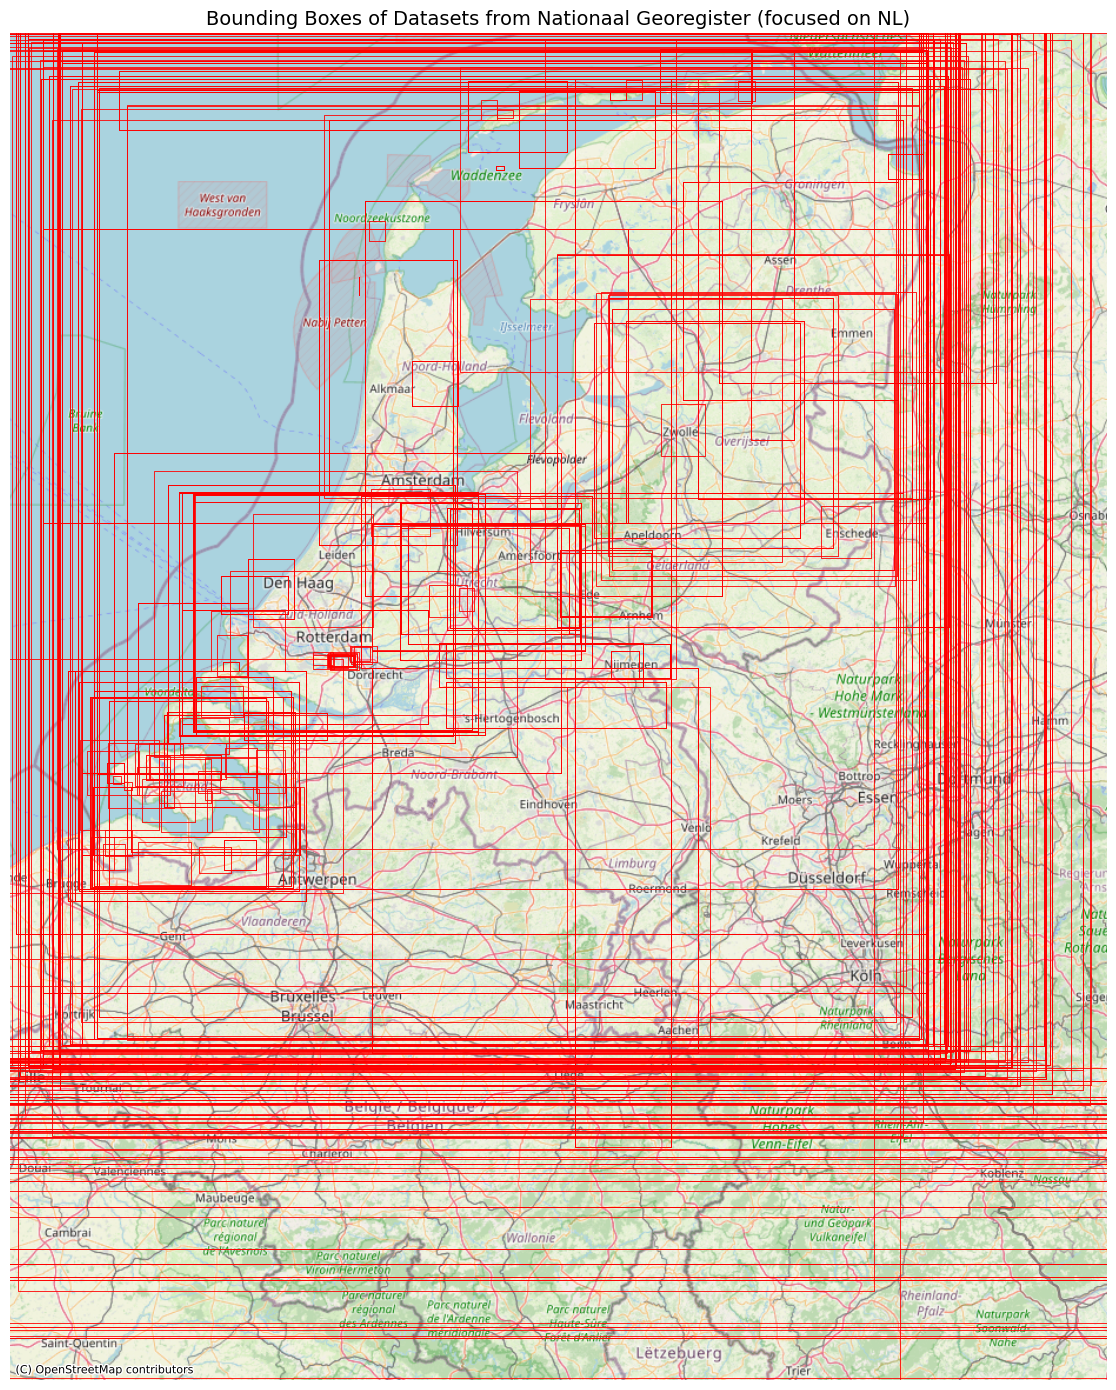

In [19]:
# Filter out records without bounding boxes
df_valid = filtered_df[filtered_df['minx'].notna()].copy()

# Create geometry column from bounding box
df_valid["geometry"] = df_valid.apply(
    lambda row: box(row["minx"], row["miny"], row["maxx"], row["maxy"]),
    axis=1)

# Convert to GeoDataFrame (WGS84)
gdf = gpd.GeoDataFrame(df_valid, geometry="geometry", crs="EPSG:4326")

# Reproject to EPSG:3857 for plotting with basemap
gdf_3857 = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))
gdf_3857.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.6)

# Focus map on the Netherlands
ax.set_xlim(330000, 900000)
ax.set_ylim(6400000, 7100000)

# Add OpenStreetMap basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Style
ax.set_title("Bounding Boxes of Datasets from Nationaal Georegister (focused on NL)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


### **Filtering datasets with bounding boxes intersecting the Veluwe region**

In [20]:
# Coordinates of a bounding box of Veluwe
lat1, lon1 = 52.487584, 6.133833
lat2, lon2 = 51.937091, 5.481064

# Convert to lon/lat order for box(minx, miny, maxx, maxy)
region_bbox = box(lon2, lat2, lon1, lat1)

# Wrap as GeoSeries to compare with your dataset
region_gdf = gpd.GeoSeries([region_bbox], crs="EPSG:4326")

# Copy filtered_df so we don't modify the original
df = filtered_df.copy()

# Filter out rows with missing bounding box coordinates
df_valid = df[df["minx"].notna()].copy()

# Build bounding box geometries
df_valid["geometry"] = df_valid.apply(
    lambda row: box(row["minx"], row["miny"], row["maxx"], row["maxy"]),
    axis=1
)

# Convert to GeoDataFrame
gdf_valid = gpd.GeoDataFrame(df_valid, geometry="geometry", crs="EPSG:4326")

# Check if each dataset intersects the Veluwe region
gdf_valid["intersects_region"] = gdf_valid.geometry.intersects(region_bbox)

# Merge the intersects_region information back into the full dataframe
df["intersects_region"] = False  # default
df.loc[gdf_valid.index, "intersects_region"] = gdf_valid["intersects_region"]

# Filter the rows that intersect with Veluwe
df_veluwe = df[df["intersects_region"] == True]

# df_veluwe now contains all original columns + 'intersects_region'


In [21]:
df_veluwe.head()

identifier  \
6   DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49  078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54  841b0f6f-3141-40dd-bec5-77e0065bd688   
69  47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84  fe45c540-e37d-11e4-b571-0800200c9a66   

                                           main_title      minx     miny  \
6   Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49  Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54           Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                   ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84  Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   

        maxx     maxy  OGS                                           OGC_URLS  \
6    7.24400  53.7100  WMS  {"WMS": ["https://geoservices.zuid-holland.nl/...   
49   7.35400  53.0120  WMS  {"WMS": ["https://services.geodataoverijssel.n...   
54   7.24000  53.6000  WMS  {"WMS": ["https://service.pdok.nl/kadaster/net...   
69   7.21097  53.4658  WMS  {"WMS": ["https://opengeodata.zeeland.nl/geose...   
84  26.23200  58.8643  WMS  {"WMS": ["https://service.pdok.nl/provincies/z...   

                                         child_layers  intersects_region  
6   ArcGIS Server Map service layers: Potentieel h...               True  
49  LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True  
54  WMS view service Beschikbare Capaciteit Elektr...               True  
69   ext_nat_nbpagzont023;natuur:ext_nat_nbpagzont023               True  
84  AM.DesignatedWaters;Download service voor zwem...               True

In [22]:
len(df_veluwe)

1329

### **Visualizing the bounding boxes that <u>intersect</u> the Veluwe region on a map**

C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\3438996298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veluwe["geometry"] = df_veluwe.apply(


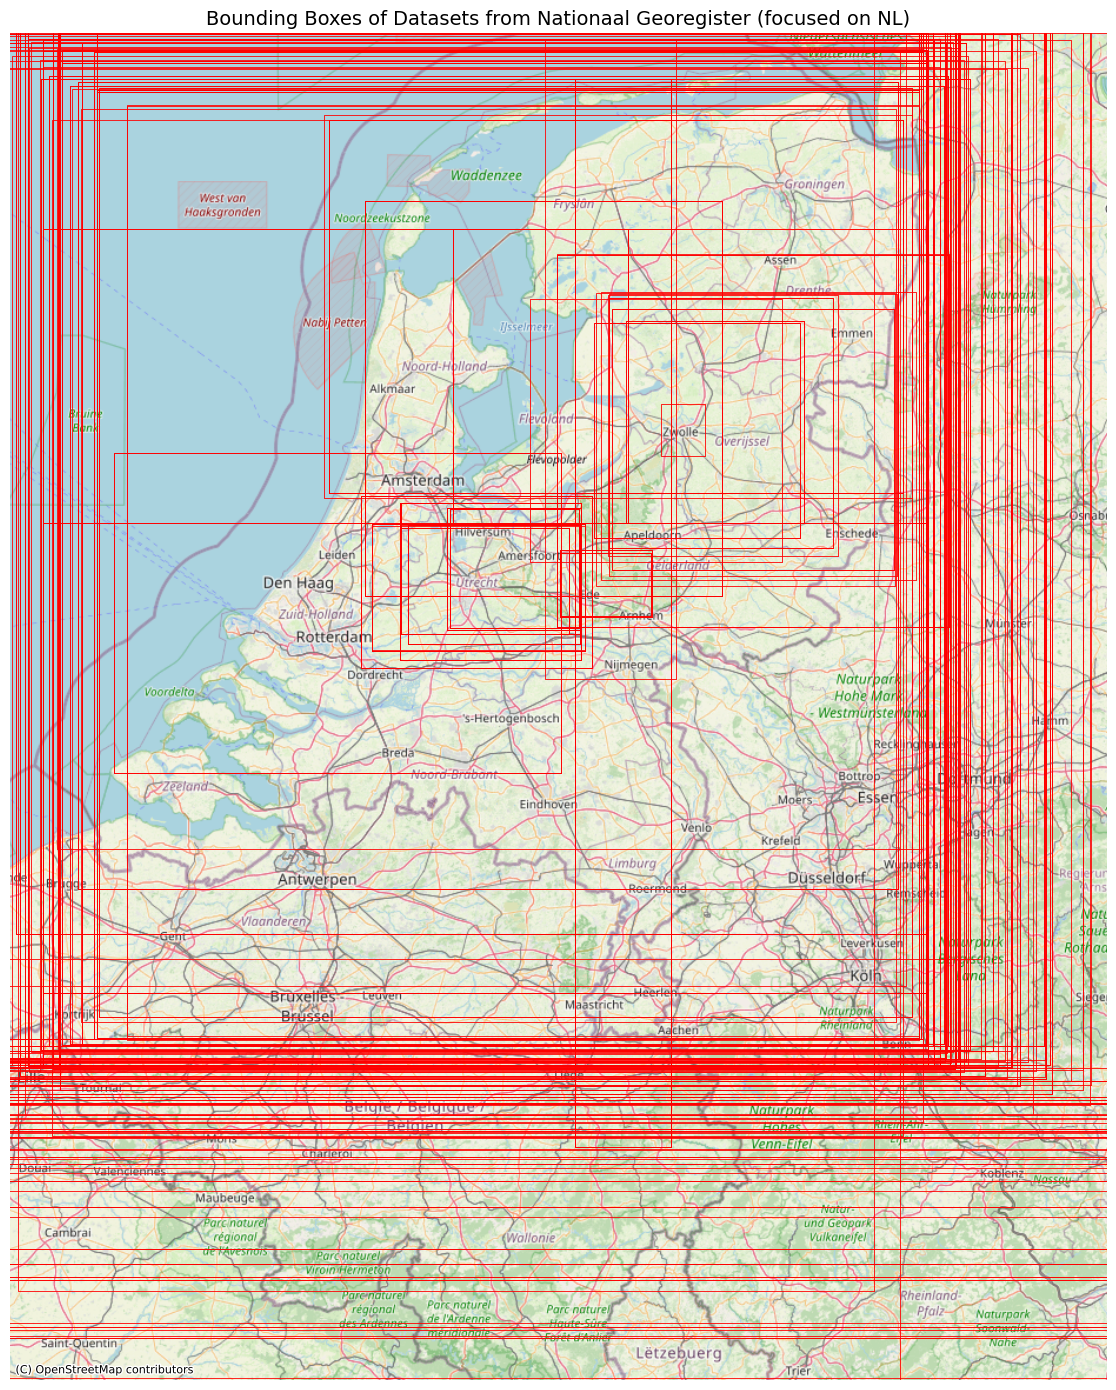

In [23]:
df_veluwe["geometry"] = df_veluwe.apply(
    lambda row: box(row["minx"], row["miny"], row["maxx"], row["maxy"]),
    axis=1)

# Convert to GeoDataFrame (WGS84)
gdf = gpd.GeoDataFrame(df_veluwe, geometry="geometry", crs="EPSG:4326")

# Reproject to EPSG:3857 for plotting with basemap
gdf_3857 = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))
gdf_3857.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.6)

# Focus map on the Netherlands
ax.set_xlim(330000, 900000)
ax.set_ylim(6400000, 7100000)

# Add OpenStreetMap basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Style
ax.set_title("Bounding Boxes of Datasets from Nationaal Georegister (focused on NL)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### **Summarizing intersection statistics with the Veluwe region**

In [24]:
print("- Intersecting bounding boxes:", df_veluwe.shape[0])
print("- Total bounding boxes:", df.shape[0])
print("- Percentage of intersecting bounding boxes: ", f"{df_veluwe.shape[0] / df.shape[0] * 100:.2f}%")

- Intersecting bounding boxes: 1329
- Total bounding boxes: 1779
- Percentage of intersecting bounding boxes:  74.70%


In [27]:
df_veluwe.head()

identifier  \
6   DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49  078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54  841b0f6f-3141-40dd-bec5-77e0065bd688   
69  47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84  fe45c540-e37d-11e4-b571-0800200c9a66   

                                           main_title      minx     miny  \
6   Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49  Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54           Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                   ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84  Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   

        maxx     maxy  OGS                                           OGC_URLS  \
6    7.24400  53.7100  WMS  {"WMS": ["https://geoservices.zuid-holland.nl/...   
49   7.35400  53.0120  WMS  {"WMS": ["https://services.geodataoverijssel.n...   
54   7.24000  53.6000  WMS  {"WMS": ["https://service.pdok.nl/kadaster/net...   
69   7.21097  53.4658  WMS  {"WMS": ["https://opengeodata.zeeland.nl/geose...   
84  26.23200  58.8643  WMS  {"WMS": ["https://service.pdok.nl/provincies/z...   

                                         child_layers  intersects_region  \
6   ArcGIS Server Map service layers: Potentieel h...               True   
49  LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True   
54  WMS view service Beschikbare Capaciteit Elektr...               True   
69   ext_nat_nbpagzont023;natuur:ext_nat_nbpagzont023               True   
84  AM.DesignatedWaters;Download service voor zwem...               True   

                                             geometry  
6   POLYGON ((7.244 51.059, 7.244 53.71, 2.994 53....  
49  POLYGON ((7.354 51.952, 7.354 53.012, 5.519 53...  
54  POLYGON ((7.24 50.73, 7.24 53.6, 3.3 53.6, 3.3...  
69  POLYGON ((7.21097 50.7539, 7.21097 53.4658, 3....  
84  POLYGON ((26.232 44.8308, 26.232 58.8643, -18....

### **Retrieving and adding abstracts for Veluwe datasets**


In [28]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from tqdm import tqdm  # for a progress bar

# Assuming your dataframe is named filtered_df

# Function to get abstract given an identifier
def fetch_abstract(identifier):
    try:
        url = f"https://www.nationaalgeoregister.nl/geonetwork/srv/api/records/{identifier}/formatters/xml"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            root = ET.fromstring(response.text)
            namespaces = {'gmd': 'http://www.isotc211.org/2005/gmd', 'gco': 'http://www.isotc211.org/2005/gco'}
            
            # Find abstract
            abstract_element = root.find('.//gmd:abstract/gco:CharacterString', namespaces)
            if abstract_element is not None and abstract_element.text:
                return abstract_element.text.strip()
            else:
                return None  # No abstract found
        else:
            return None  # Failed request
    except Exception as e:
        print(f"Error fetching abstract for {identifier}: {e}")
        return None

# Create a new column with abstracts
tqdm.pandas(desc="Fetching abstracts")  # show progress bar
df_veluwe["abstract"] = df_veluwe["identifier"].progress_apply(fetch_abstract)

# Done!


Fetching abstracts: 100%|██████████████████████████████████████████████████████████| 1329/1329 [04:29<00:00,  4.94it/s]
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\1071255704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veluwe["abstract"] = df_veluwe["identifier"].progress_apply(fetch_abstract)


### **Checkpoint 4: saving progress in metadata table**

In [29]:
#df_veluwe.to_csv("main_data_groups_v04.csv", index=False)
#df_veluwe = pd.read_csv("main_data_groups_v04.csv")

In [30]:
df_veluwe.head()

identifier  \
6   DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49  078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54  841b0f6f-3141-40dd-bec5-77e0065bd688   
69  47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84  fe45c540-e37d-11e4-b571-0800200c9a66   

                                           main_title      minx     miny  \
6   Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49  Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54           Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                   ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84  Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   

        maxx     maxy  OGS                                           OGC_URLS  \
6    7.24400  53.7100  WMS  {"WMS": ["https://geoservices.zuid-holland.nl/...   
49   7.35400  53.0120  WMS  {"WMS": ["https://services.geodataoverijssel.n...   
54   7.24000  53.6000  WMS  {"WMS": ["https://service.pdok.nl/kadaster/net...   
69   7.21097  53.4658  WMS  {"WMS": ["https://opengeodata.zeeland.nl/geose...   
84  26.23200  58.8643  WMS  {"WMS": ["https://service.pdok.nl/provincies/z...   

                                         child_layers  intersects_region  \
6   ArcGIS Server Map service layers: Potentieel h...               True   
49  LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True   
54  WMS view service Beschikbare Capaciteit Elektr...               True   
69   ext_nat_nbpagzont023;natuur:ext_nat_nbpagzont023               True   
84  AM.DesignatedWaters;Download service voor zwem...               True   

                                             geometry  \
6   POLYGON ((7.244 51.059, 7.244 53.71, 2.994 53....   
49  POLYGON ((7.354 51.952, 7.354 53.012, 5.519 53...   
54  POLYGON ((7.24 50.73, 7.24 53.6, 3.3 53.6, 3.3...   
69  POLYGON ((7.21097 50.7539, 7.21097 53.4658, 3....   
84  POLYGON ((26.232 44.8308, 26.232 58.8643, -18....   

                                             abstract  
6   In opdracht van de provincie Zuid-Holland is d...  
49  Gesloten bodemenergiesystemen kunnen tot een d...  
54  Inleiding\n\n\t\t\t\t\tBinnen het samenwerking...  
69  Begrenzing van de ontwerp leefgebieden droge d...  
84  De ongeveer 700 officiële zwemwaterlocaties wo...

### **Cleaning and standardizing child layer names**

In [31]:
def clean_child_layers(entry):
    if pd.isna(entry):
        return entry  # leave NaN entries untouched

    layers = entry.split(';')  # split by semicolon
    layers = [layer.strip() for layer in layers]  # remove extra spaces

    # Always remove duplicates first
    layers = list(dict.fromkeys(layers))  # keeps first occurrence

    # Rule (1): If more than one name, keep only the ones containing ":"
    if len(layers) > 1:
        layers_with_colon = [layer for layer in layers if ':' in layer]
        if layers_with_colon:
            layers = layers_with_colon  # only if ":" layers exist

    return ';'.join(layers) if layers else entry


In [32]:
# Apply the function
df_veluwe['child_layers'] = df_veluwe['child_layers'].apply(clean_child_layers)

C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\3015532259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veluwe['child_layers'] = df_veluwe['child_layers'].apply(clean_child_layers)


### **Relabeling WMS as WCS to capture hidden WCS links; standardize URLs to HTTPS; and remove URLs duplicated**

In [33]:
# Update 'OGC_URLS' - change WMS links to WCS links, remove duplicates, and fix only "http://" cases
def update_ogc_urls(urls_str):
    if pd.isna(urls_str):
        return urls_str
    try:
        urls = json.loads(urls_str)
        
        new_urls = {}

        # If WMS exists, replace with WCS
        if 'WMS' in urls:
            wms_urls = urls['WMS']
            wcs_urls = [u.replace('/wms?', '/wcs?') for u in wms_urls]
            new_urls['WCS'] = wcs_urls

        # If WCS already existed, keep it
        if 'WCS' in urls:
            if 'WCS' in new_urls:
                new_urls['WCS'].extend(urls['WCS'])
            else:
                new_urls['WCS'] = urls['WCS']

        # Clean all WCS urls:
        if 'WCS' in new_urls:
            cleaned_wcs_urls = []
            for u in new_urls['WCS']:
                u = u.strip()
                # Only replace if "http://" is present at the beginning
                if u.startswith('http://'):
                    u = u.replace('http://', 'https://', 1)
                cleaned_wcs_urls.append(u)

            # Remove duplicates after cleaning
            new_urls['WCS'] = sorted(list(set(cleaned_wcs_urls)))

        return json.dumps(new_urls, ensure_ascii=False)
    
    except Exception as e:
        return urls_str  # If parsing error, return original

df_veluwe['OGC_URLS'] = df_veluwe['OGC_URLS'].apply(update_ogc_urls)


C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\32363263.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veluwe['OGC_URLS'] = df_veluwe['OGC_URLS'].apply(update_ogc_urls)


### **Checkpoint 5: saving progress in metadata table**

In [34]:
#df_veluwe.to_csv("main_data_groups_v05.csv", index=False)
#df_veluwe = pd.read_csv("main_data_groups_v05.csv")

In [35]:
df_veluwe.head()

identifier  \
6   DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49  078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54  841b0f6f-3141-40dd-bec5-77e0065bd688   
69  47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84  fe45c540-e37d-11e4-b571-0800200c9a66   

                                           main_title      minx     miny  \
6   Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49  Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54           Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                   ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84  Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   

        maxx     maxy  OGS                                           OGC_URLS  \
6    7.24400  53.7100  WMS  {"WCS": ["https://geoservices.zuid-holland.nl/...   
49   7.35400  53.0120  WMS  {"WCS": ["https://services.geodataoverijssel.n...   
54   7.24000  53.6000  WMS  {"WCS": ["https://service.pdok.nl/kadaster/net...   
69   7.21097  53.4658  WMS  {"WCS": ["https://opengeodata.zeeland.nl/geose...   
84  26.23200  58.8643  WMS  {"WCS": ["https://service.pdok.nl/provincies/z...   

                                         child_layers  intersects_region  \
6   ArcGIS Server Map service layers: Potentieel h...               True   
49  LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True   
54  WMS view service Beschikbare Capaciteit Elektr...               True   
69                        natuur:ext_nat_nbpagzont023               True   
84  AM.DesignatedWaters;Download service voor zwem...               True   

                                             geometry  \
6   POLYGON ((7.244 51.059, 7.244 53.71, 2.994 53....   
49  POLYGON ((7.354 51.952, 7.354 53.012, 5.519 53...   
54  POLYGON ((7.24 50.73, 7.24 53.6, 3.3 53.6, 3.3...   
69  POLYGON ((7.21097 50.7539, 7.21097 53.4658, 3....   
84  POLYGON ((26.232 44.8308, 26.232 58.8643, -18....   

                                             abstract  
6   In opdracht van de provincie Zuid-Holland is d...  
49  Gesloten bodemenergiesystemen kunnen tot een d...  
54  Inleiding\n\n\t\t\t\t\tBinnen het samenwerking...  
69  Begrenzing van de ontwerp leefgebieden droge d...  
84  De ongeveer 700 officiële zwemwaterlocaties wo...

### **Cleaning "child_layers": apply fixes, infer prefixes, and update WCS URLs**

In [36]:
def extract_prefix_from_url(url):
    """Extract the part between '/geo/' and '/wcs'."""
    parsed = urlparse(url)
    path = parsed.path.lower()
    if "/geo/" in path and "/wcs" in path:
        after_geo = path.split("/geo/")[1]
        prefix = after_geo.split("/")[0]
        return prefix
    return None

def clean_and_update_child_layers(df):
    """Clean and update child_layers and OGC_URLS based on user-specified rules."""

    def clean_row(row):
        child_layers = row.get("child_layers")
        ogc_urls = row.get("OGC_URLS")

        if pd.isna(child_layers) or pd.isna(ogc_urls):
            return None, None

        # Load OGC_URLS
        try:
            urls = json.loads(ogc_urls)
        except:
            return None, None

        # Collect all WCS urls
        wcs_urls = []
        if "WCS" in urls:
            wcs_urls = urls["WCS"]

        updated_layers = []
        for layer in child_layers.split(";"):
            layer = layer.strip()

            # 1. Skip if contains spaces
            if " " in layer:
                continue

            # 2. Replace 'dank:' with 'ank:' and correct WCS URL
            if layer.startswith("dank:"):
                layer = layer.replace("dank:", "ank:")
                wcs_urls = ["https://data.rivm.nl/geo/ank/wcs?"]

            # 3. Clean all WCS urls
            cleaned_wcs_urls = []
            for url in wcs_urls:
                url = url.strip()

                # Fix url endings: /wcs → /wcs? , /wms → /wcs?
                if url.endswith("/wcs"):
                    url = url + "?"
                if url.endswith("/wms"):
                    url = url[:-4] + "/wcs?"

                # Remove 'request=GetCapabilities' if present
                if "request=GetCapabilities" in url:
                    url = url.replace("request=GetCapabilities", "")
                    url = url.rstrip("&?") + "?"

                cleaned_wcs_urls.append(url)
            wcs_urls = cleaned_wcs_urls

            # 4. If no ":", infer prefix from URL
            if ":" not in layer and wcs_urls:
                prefix = extract_prefix_from_url(wcs_urls[0])
                if prefix:
                    layer = f"{prefix}:{layer}"

            updated_layers.append(layer)

        # If valid layers
        if updated_layers:
            updated_layers = sorted(list(set(updated_layers)))  # Remove duplicates within the same row
            return ";".join(updated_layers), json.dumps({"WCS": sorted(list(set(wcs_urls)))}, ensure_ascii=False)
        else:
            return None, None

    # Apply row-wise
    tqdm.pandas(desc="Cleaning child_layers and fixing URLs")
    result = df.progress_apply(lambda row: clean_row(row), axis=1)

    # Update df
    df["child_layers"] = result.map(lambda x: x[0])
    df["OGC_URLS"] = result.map(lambda x: x[1])

    # 5. Remove duplicated child layers across different rows
    seen_layers = set()

    def remove_duplicates(layer_str):
        if pd.isna(layer_str):
            return layer_str
        layers = []
        for l in layer_str.split(";"):
            if l not in seen_layers:
                seen_layers.add(l)
                layers.append(l)
        return ";".join(layers) if layers else None

    df["child_layers"] = df["child_layers"].apply(remove_duplicates)

    return df

In [37]:
# Applying the function
df_veluwe = clean_and_update_child_layers(df_veluwe)

Cleaning child_layers and fixing URLs: 100%|████████████████████████████████████| 1329/1329 [00:00<00:00, 52524.15it/s]
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\1617633766.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["child_layers"] = result.map(lambda x: x[0])
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\1617633766.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OGC_URLS"] = result.map(lambda x: x[1])
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\1617633766.py:100: Settin

### **Checkpoint 6: saving progress in metadata table**

In [38]:
#df_veluwe.to_csv("main_data_groups_v06.csv", index=False)
#df_veluwe = pd.read_csv("main_data_groups_v06.csv")

In [40]:
df_veluwe

identifier  \
6     DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49    078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54    841b0f6f-3141-40dd-bec5-77e0065bd688   
69    47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84    fe45c540-e37d-11e4-b571-0800200c9a66   
...                                    ...   
9269  5eaaff8c-c9e1-47b9-a194-6ee727e8bd2d   
9270  600e5b27-7175-4a80-bd15-9cbba518c797   
9271  c07cbf23-ef3d-4912-88b3-a376d3dbdc8f   
9273  e44b65e1-573f-4e32-9221-f5d0a60643a6   
9295  f97f50f1-4fe7-47f7-b4a3-1221d8938577   

                                             main_title      minx     miny  \
6     Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49    Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54             Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                     ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84    Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   
...                                                 ...       ...      ...   
9269    BRO - Geotechnisch booronderzoek (BHR-GT) as-is   2.53800  50.7500   
9270  Waterplantenbedekking IJsselmeergebied - Aarve...   5.03300  52.2510   
9271                   Hoogtebestand Westerschelde 2015   3.11900  50.6700   
9273                Hoogtebestand kust 5m grid 2021 DTM   3.11900  50.6700   
9295                                     Spoorwegen WMS   1.62910  50.4606   

          maxx     maxy      OGS  \
6      7.24400  53.7100      WMS   
49     7.35400  53.0120      WMS   
54     7.24000  53.6000      WMS   
69     7.21097  53.4658      WMS   
84    26.23200  58.8643      WMS   
...        ...      ...      ...   
9269   7.22700  55.7640      WMS   
9270   5.85200  53.0820  WCS;WMS   
9271   7.25300  53.6120  WCS;WMS   
9273   7.25300  53.6120  WCS;WMS   
9295   8.59420  53.8431      WMS   

                                               OGC_URLS  \
6                                                  None   
49    {"WCS": ["https://services.geodataoverijssel.n...   
54                                                 None   
69    {"WCS": ["https://opengeodata.zeeland.nl/geose...   
84    {"WCS": ["https://service.pdok.nl/provincies/z...   
...                                                 ...   
9269                                               None   
9270  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9271  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9273  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9295                                               None   

                                           child_layers  intersects_region  \
6                                                  None               True   
49    LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True   
54                                                 None               True   
69                          natuur:ext_nat_nbpagzont023               True   
84                                  AM.DesignatedWaters               True   
...                                                 ...                ...   
9269                                               None               True   
9270                                               None               True   
9271                                               None               True   
9273                                               None               True   
9295                                               None               True   

                                               geometry  \
6     POLYGON ((7.244 51.059, 7.244 53.71, 2.994 53....   
49    POLYGON ((7.354 51.952, 7.354 53.012, 5.519 53...   
54    POLYGON ((7.24 50.73, 7.24 53.6, 3.3 53.6, 3.3...   
69    POLYGON ((7.21097 50.7539, 7.21097 53.4658, 3....   
84    POLYGON ((26.232 44.8308, 26.232 58.8643, -18....   
...                                                 ...   
9269  POLYGON ((7.227 50.75, 7.227 55.764, 2.538 5

### **Visualizing the layers on a map**

In [45]:
# Layer info

layer_id = "alo:rivm_nsl_20190509_gm_pm102017"
wcs_url = "https://data.rivm.nl/geo/alo/wcs?"

# Open WCS
wcs = WebCoverageService(wcs_url, version='1.0.0')

# Project Veluwe polygon to 28992
veluwe_28992 = veluwe.to_crs(epsg=28992)
veluwe_bounds = veluwe_28992.total_bounds

# Request raster
response = wcs.getCoverage(
    identifier=layer_id,
    crs='EPSG:28992',
    #bbox=tuple(veluwe_bounds),
    format='GeoTIFF',
    width=512,
    height=512
)

# Load raster into memory
with MemoryFile(response.read()) as memfile:
    with memfile.open() as dataset:
        data = dataset.read(1)
        transform = dataset.transform  # You forgot to extract 'transform' before!

# Mask the -9999 values
data = np.where(data == -9999, np.nan, data)

# Prepare outlines
netherlands_proj = netherlands.to_crs(epsg=28992)
veluwe_proj = veluwe.to_crs(epsg=28992)

# Title
layer_title = wcs.contents[layer_id].title

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Left: Raster + Netherlands outline
ax1 = axes[0]
ax1.set_title("Raster (Veluwe Area) + Netherlands Outline")
show(data, transform=transform, ax=ax1, cmap="viridis")
netherlands_proj.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")

# Right: Raster + Veluwe outline + colorbar
ax2 = axes[1]
ax2.set_title(f"Raster Layer: {layer_title}")
im = show(data, transform=transform, ax=ax2, cmap="viridis")
veluwe_proj.boundary.plot(ax=ax2, edgecolor='red', linewidth=1)
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")

# Add colorbar
cbar = fig.colorbar(im.get_images()[0], ax=ax2, orientation='vertical')
cbar.set_label("Raster Value")

plt.tight_layout()
plt.show()


RasterioIOError: '/vsimem/a2b795d1-27d6-47f8-8d96-95e430bedf8d/a2b795d1-27d6-47f8-8d96-95e430bedf8d.tif' not recognized as a supported file format.

### **Checking if child layers are downloadable via WCS**

In [46]:
def check_layer_downloadability(row):
    """Check if layer(s) in a row can be downloaded as real rasters."""
    results = []
    
    try:
        # Read OGC_URLS and child_layers
        ogc_urls = json.loads(row['OGC_URLS'])
        child_layers = row['child_layers']
        
        if pd.isna(child_layers) or 'WCS' not in ogc_urls:
            return None  # No child layers or WCS URL available
        
        base_wcs_urls = ogc_urls['WCS']
        if isinstance(base_wcs_urls, list):
            wcs_url = base_wcs_urls[0]  # 🛠 Only take the first URL
        else:
            wcs_url = base_wcs_urls  # If it's a string already

        # Make sure URL ends correctly
        if wcs_url.endswith('/wcs') or wcs_url.endswith('/wms'):
            wcs_url = wcs_url + '?'
        elif not wcs_url.endswith('?'):
            wcs_url = wcs_url + '?'
        
        # Process each child layer
        layers = child_layers.split(';')
        
        for layer in layers:
            layer = layer.strip()
            if not layer:
                results.append('no')
                continue

            success = False

            try:
                # Try to create WCS object
                wcs = WebCoverageService(wcs_url, version='1.0.0')

                # Use a small dummy bbox (quick and small request)
                test_bbox = (5.0, 52.0, 5.1, 52.1)

                # Try to request
                response = wcs.getCoverage(
                    identifier=layer,
                    crs='EPSG:4326',
                    bbox=test_bbox,
                    format='GeoTIFF',
                    width=10,
                    height=10
                )

                # Try to open with rasterio
                with MemoryFile(response.read()) as memfile:
                    with memfile.open() as dataset:
                        _ = dataset.read(1)  # Read band 1 just to validate

                success = True

            except Exception:
                success = False

            results.append('yes' if success else 'no')
        
        return ';'.join(results)
    
    except Exception as e:
        return None

# -------------------
# Applying in the dataframe
# -------------------
tqdm.pandas(desc="Checking downloadability of layers")
df_veluwe['return_image'] = df_veluwe.progress_apply(check_layer_downloadability, axis=1)


Checking downloadability of layers: 100%|██████████████████████████████████████████| 1329/1329 [28:10<00:00,  1.27s/it]
C:\Users\hudso\AppData\Local\Temp\ipykernel_7280\506400900.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veluwe['return_image'] = df_veluwe.progress_apply(check_layer_downloadability, axis=1)


### **Checkpoint 7: saving progress in metadata table**

In [47]:
#df_veluwe.to_csv("main_data_groups_v07.csv", index=False)
#df_veluwe = pd.read_csv("main_data_groups_v07.csv")

In [49]:
df_veluwe

identifier  \
6     DBB6A3D1-0021-4A53-BC6D-23BD51EB5999   
49    078b82e7-9b9f-4cf4-9ecc-a1fb87806777   
54    841b0f6f-3141-40dd-bec5-77e0065bd688   
69    47ef3cd4-adc2-4cfc-8e90-dde7dbc45c85   
84    fe45c540-e37d-11e4-b571-0800200c9a66   
...                                    ...   
9269  5eaaff8c-c9e1-47b9-a194-6ee727e8bd2d   
9270  600e5b27-7175-4a80-bd15-9cbba518c797   
9271  c07cbf23-ef3d-4912-88b3-a376d3dbdc8f   
9273  e44b65e1-573f-4e32-9221-f5d0a60643a6   
9295  f97f50f1-4fe7-47f7-b4a3-1221d8938577   

                                             main_title      minx     miny  \
6     Potentieel hoge temperatuuropslag Zand van Bru...   2.99400  51.0590   
49    Potentie ondergrond voor gesloten bodemenergie...   5.51900  51.9520   
54             Beschikbare capaciteit elektriciteitsnet   3.30000  50.7300   
69                     ZoekGebiedAgrarisch Ontwerp 2023   3.37087  50.7539   
84    Zwemwater (provinciaal en Rijkswateren) uit Zw... -18.13860  44.8308   
...                                                 ...       ...      ...   
9269    BRO - Geotechnisch booronderzoek (BHR-GT) as-is   2.53800  50.7500   
9270  Waterplantenbedekking IJsselmeergebied - Aarve...   5.03300  52.2510   
9271                   Hoogtebestand Westerschelde 2015   3.11900  50.6700   
9273                Hoogtebestand kust 5m grid 2021 DTM   3.11900  50.6700   
9295                                     Spoorwegen WMS   1.62910  50.4606   

          maxx     maxy      OGS  \
6      7.24400  53.7100      WMS   
49     7.35400  53.0120      WMS   
54     7.24000  53.6000      WMS   
69     7.21097  53.4658      WMS   
84    26.23200  58.8643      WMS   
...        ...      ...      ...   
9269   7.22700  55.7640      WMS   
9270   5.85200  53.0820  WCS;WMS   
9271   7.25300  53.6120  WCS;WMS   
9273   7.25300  53.6120  WCS;WMS   
9295   8.59420  53.8431      WMS   

                                               OGC_URLS  \
6                                                  None   
49    {"WCS": ["https://services.geodataoverijssel.n...   
54                                                 None   
69    {"WCS": ["https://opengeodata.zeeland.nl/geose...   
84    {"WCS": ["https://service.pdok.nl/provincies/z...   
...                                                 ...   
9269                                               None   
9270  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9271  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9273  {"WCS": ["https://geo.rijkswaterstaat.nl/servi...   
9295                                               None   

                                           child_layers  intersects_region  \
6                                                  None               True   
49    LIP_Potentie_ondergrond_voor_gesloten_bodemene...               True   
54                                                 None               True   
69                          natuur:ext_nat_nbpagzont023               True   
84                                  AM.DesignatedWaters               True   
...                                                 ...                ...   
9269                                               None               True   
9270                                               None               True   
9271                                               None               True   
9273                                               None               True   
9295                                               None               True   

                                               geometry  \
6     POLYGON ((7.244 51.059, 7.244 53.71, 2.994 53....   
49    POLYGON ((7.354 51.952, 7.354 53.012, 5.519 53...   
54    POLYGON ((7.24 50.73, 7.24 53.6, 3.3 53.6, 3.3...   
69    POLYGON ((7.21097 50.7539, 7.21097 53.4658, 3....   
84    POLYGON ((26.232 44.8308, 26.232 58.8643, -18....   
...                                                 ...   
9269  POLYGON ((7.227 50.75, 7.227 55.764, 2.538 5

### **Summarizing downloadability results for WCS layers**

In [50]:
from collections import Counter

# 1. Drop missing values
non_null = df_veluwe['return_image'].dropna()

# 2. Split every string by ";" and flatten into a list
all_labels = []
for item in non_null:
    all_labels.extend(item.split(';'))

# 3. Count "yes" and "no"
counts = Counter(all_labels)

# 4. Show results
print(counts)

Counter({'no': 1301, 'yes': 186})


### **Creating a square bounding box around the Veluwe region**


In [51]:
veluwe_28992 = veluwe.to_crs(epsg=28992)
veluwe_bounds = tuple(veluwe_28992.total_bounds)

# Original bounds
minx, miny, maxx, maxy = veluwe_28992.total_bounds

# Width and height
width = maxx - minx
height = maxy - miny

# Find the bigger side
max_side = max(width, height)

# Center coordinates
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2

# Create new square bounds
half_side = max_side / 2
square_minx = center_x - half_side
square_maxx = center_x + half_side
square_miny = center_y - half_side
square_maxy = center_y + half_side

# Now the bounding box is square
square_bounds = np.array([square_minx, square_miny, square_maxx, square_maxy])

print(square_bounds)

[156913.38412907 439295.44043112 221547.71616791 503929.77246997]


In [52]:
veluwe_28992.total_bounds

array([168572.25712971, 439295.44043112, 209888.84316726, 503929.77246997])

In [53]:
square_bounds

array([156913.38412907, 439295.44043112, 221547.71616791, 503929.77246997])

### **Compiling descriptive metadata for downloadable layers**

In [54]:
# 1. Define output folder
output_folder = r"C:\Users\hudso\OneDrive\Documents\02. WUR\11. INTERNSHIP\05 python_project\output\image"
os.makedirs(output_folder, exist_ok=True)

# 2. Filter only rows where 'return_image' contains "yes"
df_download = df_veluwe[df_veluwe['return_image'].str.contains('yes', na=False)].copy()

# 3. Create an empty list to collect metadata
results = []

# 4. Loop through each row
for idx, row in tqdm(df_download.iterrows(), total=len(df_download), desc="Checking layer metadata"):
    try:
        # Parse the OGC_URLS field
        urls = json.loads(row['OGC_URLS'])
        wcs_url = urls.get('WCS', [None])[0]  # Only keep the WCS URL cleanly
        if not wcs_url:
            continue

        # Open WCS connection
        wcs = WebCoverageService(wcs_url, version='1.0.0')

        # Read layer names and return flags
        layer_names = row['child_layers'].split(';')
        return_flags = row['return_image'].split(';')

        # Also extract the main_title and abstract
        main_title = row.get('main_title', 'not_available')
        abstract = row.get('abstract', 'not_available')

        for layer_name, flag in zip(layer_names, return_flags):
            layer_name = layer_name.strip()
            flag = flag.strip()

            if flag != 'yes':
                continue  # Only process layers marked with 'yes'

            # Proper filename: replace ":" and ";" by "_"
            safe_layer_name = layer_name.replace(":", "_").replace(";", "_")

            try:
                # Build DescribeCoverage URL
                describe_url = f"{wcs_url}?service=WCS&version=1.0.0&request=DescribeCoverage&coverage={layer_name}"

                # Send request
                response = requests.get(describe_url)
                if response.status_code != 200:
                    raise Exception(f"DescribeCoverage request failed with status code {response.status_code}")

                # Parse XML
                root = ET.fromstring(response.content)

                # Find CRS
                srs_element = root.find(".//{http://www.opengis.net/gml}Envelope")
                if srs_element is not None:
                    crs = srs_element.attrib.get('srsName', 'not_available')
                else:
                    crs = 'not_available'

                # Find pixel size (offset vectors)
                offset_vectors = root.findall(".//{http://www.opengis.net/gml}offsetVector")
                if len(offset_vectors) >= 2:
                    offset_x_text = offset_vectors[0].text
                    offset_y_text = offset_vectors[1].text
                    offset_x = float(offset_x_text.strip().split()[0])
                    offset_y = float(offset_y_text.strip().split()[1])
                    pixel_size_x = abs(offset_x)
                    pixel_size_y = abs(offset_y)
                    original_resolution = f"{pixel_size_x} x {pixel_size_y} meters"
                else:
                    original_resolution = 'not_available'

                # Add to results
                results.append({
                    "main_title": main_title,
                    "layer_name": safe_layer_name,
                    "original_resolution": original_resolution,
                    "original_CRS": crs,
                    "abstract": abstract,
                    "OGC_URLS": wcs_url,  # only the WCS URL, beautified
                    "return_image": flag  # add the respective return flag
                })

            except Exception as meta_error:
                results.append({
                    "main_title": main_title,
                    "layer_name": safe_layer_name,
                    "original_resolution": "not_available",
                    "original_CRS": "not_available",
                    "abstract": abstract,
                    "OGC_URLS": wcs_url,  # keep beautified even in error
                    "return_image": flag
                })
                print(f"Metadata error for layer {safe_layer_name}: {meta_error}")

    except Exception as e:
        print(f"General error at row {idx} / layer {layer_name}: {e}")

# 5. Convert to DataFrame
df_layers_metadata = pd.DataFrame(results)

# 5.1 Sort by main_title
df_layers_metadata = df_layers_metadata.sort_values(by="main_title", ascending=True)

# 6. Save results
df_layers_metadata.to_csv(Path(output_folder) / "layers_metadata2.csv", index=False)

print("Done! Metadata collected for all layers.")


Checking layer metadata:  91%|█████████████████████████████████████████████████▉     | 129/142 [00:38<00:03,  4.28it/s]

Metadata error for layer dtm_05m: DescribeCoverage request failed with status code 400


Checking layer metadata:  94%|███████████████████████████████████████████████████▉   | 134/142 [00:39<00:01,  4.94it/s]

Metadata error for layer dsm_05m: DescribeCoverage request failed with status code 400


Checking layer metadata: 100%|███████████████████████████████████████████████████████| 142/142 [00:41<00:00,  3.46it/s]

Done! Metadata collected for all layers.


### **Downloading raster images from WCS Layers**

In [ ]:
# Choose pixel size
pixel_size = 10

In [ ]:
import os
import requests
import json
from pathlib import Path
from owslib.wcs import WebCoverageService
from tqdm import tqdm

# 1. Define output folder
output_folder = r"C:\Users\hudso\OneDrive\Documents\02. WUR\11. INTERNSHIP\05 python_project\output\image"
os.makedirs(output_folder, exist_ok=True)

# 2. Project Veluwe polygon to 28992 once
veluwe_28992 = veluwe.to_crs(epsg=28992)
veluwe_bounds = tuple(veluwe_28992.total_bounds)

# 3. Filter only rows where 'return_image' contains "yes"
df_download = df_veluwe[df_veluwe['return_image'].str.contains('yes', na=False)].copy()

# 4. Loop through each row

for idx, row in tqdm(df_download.iterrows(), total=len(df_download), desc="Downloading images"):
    try:
        urls = json.loads(row['OGC_URLS'])
        wcs_url = urls.get('WCS', [None])[0]
        if not wcs_url:
            continue

        wcs = WebCoverageService(wcs_url, version='1.0.0')
        layer_names = row['child_layers'].split(';')
        return_flags = row['return_image'].split(';')

        for layer_name, flag in zip(layer_names, return_flags):
            layer_name = layer_name.strip()
            flag = flag.strip()

            if flag != 'yes':
                continue

            safe_layer_name = layer_name.replace(":", "_").replace(";", "_")
            output_path = Path(output_folder) / f"{safe_layer_name}.tif"

            minx, miny, maxx, maxy = square_bounds
            width_meters = maxx - minx
            height_meters = maxy - miny

            width_pixels = int(round(width_meters / pixel_size))
            height_pixels = int(round(height_meters / pixel_size))

            response = wcs.getCoverage(
                identifier=layer_name,
                crs='EPSG:28992',
                bbox=square_bounds,
                format='GeoTIFF',
                width=width_pixels,
                height=height_pixels
            )

            with open(output_path, 'wb') as f:
                f.write(response.read())

    except Exception as e:
        print(f"Error at row {idx} / layer {layer_name}: {e}")


---